# **Fine-tuning for Image Classification with 🤗 Transformers in TensorFlow**

This notebook shows how to fine-tune any pretrained Vision model for Image Classification on a custom dataset. The idea is to add a randomly initialized classification head on top of a pre-trained encoder, and fine-tune the model altogether on a labeled dataset.

## `tf.data` and `tensorflow_datasets`

This notebook leverages [`tf.data`](https://www.tensorflow.org/guide/data_performance) and [`tensorflow_datasets`](https://www.tensorflow.org/datasets) (`tfds` for short) loading and preparing a custom dataset (namely, [`tf_flowers`](https://www.tensorflow.org/datasets/catalog/tf_flowers) in this tutorial). If you want to use a dataset that is not present in `tfds` then you can follow [this guide](https://www.tensorflow.org/tutorials/load_data/images). 

## Any model

This notebook is built to run on any image classification dataset with any vision model checkpoint from the [Model Hub](https://huggingface.co/) as long as that model has a version with an image classification head, such as:

* [TFViTForImageClassification](https://huggingface.co/docs/transformers/model_doc/vit#transformers.TFViTForImageClassification),
* [TFSwinForImageClassification](https://huggingface.co/docs/transformers/main/en/model_doc/swin#transformers.TFSwinForImageClassification),
* [TFConvNextForImageClassification](https://huggingface.co/docs/transformers/model_doc/convnext#transformers.TFConvNextForImageClassification) 

In short, any model supported by [TFAutoModelForImageClassification](https://huggingface.co/docs/transformers/model_doc/auto#transformers.TFAutoModelForImageClassification).


## Data augmentation

This notebook leverages the ops offered by the [`tf.image`](https://www.tensorflow.org/api_docs/python/tf/image/) module for data augmentation. We will soon be adding examples of data augmentation with libraries like [`albumentations`](https://albumentations.ai/).


---

Depending on the model and the GPU you are using, you might need to adjust the batch size to avoid out-of-memory errors. Set those two parameters, then the rest of the notebook should run smoothly.

In this notebook, we'll fine-tune from the [`vit-base-patch16-224-in21k`](https://huggingface.co/google/vit-base-patch16-224-in21k) checkpoint, but note that there are many more available on the hub.

In [1]:
model_id = "google/vit-base-patch16-224-in21k" # Pre-trained model from which to fine-tune.
batch_size = 32 # Batch size for training and evaluation.

Before we start, let's install the `transformers` libraries.

In [2]:
!pip install -q transformers

     |████████████████████████████████| 4.2 MB 6.9 MB/s 
     |████████████████████████████████| 6.6 MB 50.4 MB/s 
     |████████████████████████████████| 596 kB 48.7 MB/s 
     |████████████████████████████████| 86 kB 6.4 MB/s 


If you're executing this notebook from [Google Colab](https://colab.research.google.com/) then you won't need to install TensorFlow and TensorFlow Datasets. Otherwise, you can install them with the command below:

In [ ]:
# !pip install tensorflow tensorflow_datasets

To be able to share your model with the community and generate results like the one shown in the picture below via the inference API, there are a few more steps to follow.

First you have to store your authentication token from the Hugging Face website (sign up [here](https://huggingface.co/join) if you haven't already!) then execute the following cell and input your token:

In [2]:
from huggingface_hub import notebook_login

notebook_login()

Then you need to install Git-LFS to upload your model checkpoints:

In [3]:
%%capture
!sudo apt -qq install git-lfs
!git config --global credential.helper store

## Fine-tuning on an image classification task

In this notebook, we will see how to fine-tune one of the [🤗 Transformers](https://github.com/huggingface/transformers) vision models on an Image Classification dataset.

Given an image, the goal is to predict an appropriate class for it, like "tiger". The screenshot below is taken from a [ViT fine-tuned on ImageNet-1k](https://huggingface.co/google/vit-base-patch16-224) - try out the inference widget!

<br>
<center>
<img src="https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/tiger_image.png" alt="drawing" width="600"/>
</center>


### Loading the dataset

As mentioned above, we'll use `tfds` to load our dataset. In the below code cells, we first import the libraries, we then define a few useful constants, and finally, we load the `tf_flowers` dataset. 

In [4]:
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow import keras

In [5]:
# Model
image_resolution = [224, 224, 3]

# Dataset
classes = [
    "dandelion",
    "daisy",
    "tulips",
    "sunflowers",
    "roses",
]  # Don't change the order

# Other constants
mean = tf.constant([0.485 * 255, 0.456 * 255, 0.406 * 255])  # imagenet mean
std = tf.constant([0.229 * 255, 0.224 * 255, 0.225 * 255])  # imagenet std

2022-05-27 13:51:05.514956: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-27 13:51:07.301929: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38450 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:00:04.0, compute capability: 8.0


In [6]:
train_dataset, val_dataset = tfds.load(
    "tf_flowers",
    split=["train[:90%]", "train[90%:]"],
    as_supervised=True,
    try_gcs=False,  # gcs_path is necessary for tpu,
)

num_train = tf.data.experimental.cardinality(train_dataset)
num_val = tf.data.experimental.cardinality(val_dataset)
print(f"Number of training examples: {num_train}")
print(f"Number of validation examples: {num_val}")

Number of training examples: 3303
Number of validation examples: 367


### Preparing the dataset

In this section, we'll prepare the dataset so that it can be used for training. In a nutshell, this is what we are going to do:

* Resize the images to have a uniform resolution (224x224x3 in our case).
* Apply augmentation operations (like random flipping, cropping, etc.) to the training set.
* Normalize the images.
* Batch the images and labels.

We'll write a utility function for doing these. 

In [7]:
def make_dataset(
    dataset: tf.data.Dataset, train: bool, image_resolution=image_resolution
):
    def preprocess(image, label):
        image = tf.cast(image, tf.float32)

        # For training, do augmentation.
        if train:
            image = tf.image.random_flip_left_right(image)
            image = tf.image.random_flip_up_down(image)
            # First resize the image to a slightly bigger than expected resolution,
            # and then take a random crop.
            image = tf.image.resize(
                image, (image_resolution[0] + 20, image_resolution[1] + 20)
            )
            image = tf.image.random_crop(image, size=image_resolution)
        else:
            image = tf.image.resize(
                image, size=(image_resolution[0], image_resolution[1])
            )
        image = (image - mean) / std  # Normalization.
        return image, label

    # Shuffle the training images.
    if train:
        dataset = dataset.shuffle(batch_size * 10)

    dataset = dataset.map(preprocess, tf.data.AUTOTUNE).batch(batch_size)
    # Transpose because the `transformers` model has a leading channel dimension.
    dataset = dataset.map(
        lambda x, y: (tf.transpose(x, [0, 3, 1, 2]), y), tf.data.AUTOTUNE
    )
    # We apply prefetching to prepare a couple of batches async on CPU
    # so that our model doesn't starve for data.
    return dataset.prefetch(tf.data.AUTOTUNE)

In [8]:
train_dataset = make_dataset(train_dataset, True)
val_dataset = make_dataset(val_dataset, False)

Let's visualize a couple of samples. 

In [9]:
import matplotlib.pyplot as plt

2022-05-27 13:51:11.487699: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


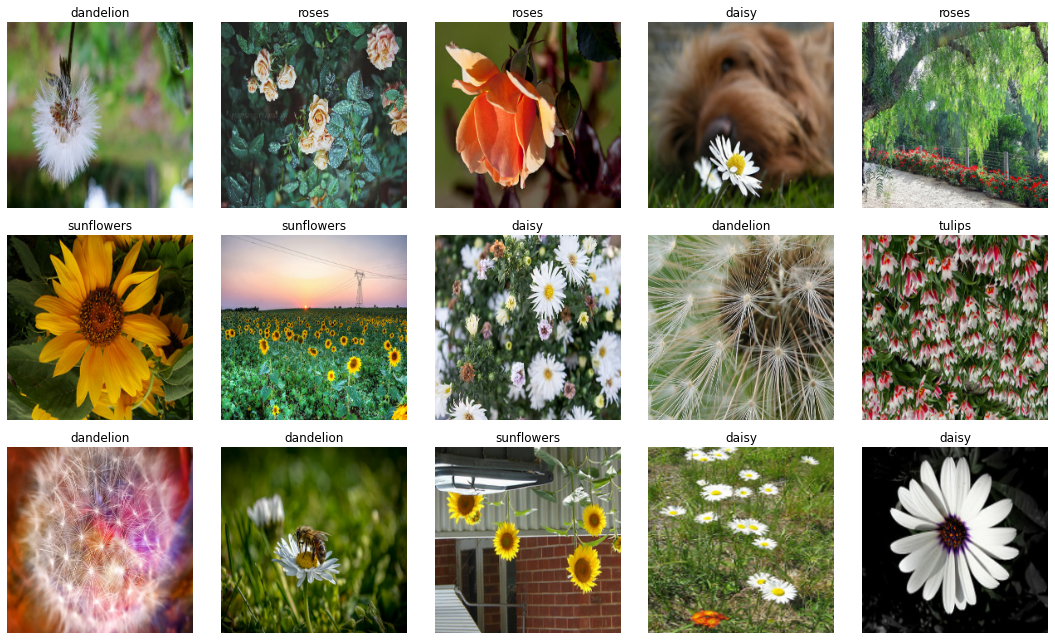

In [10]:
sample_images, sample_labels = next(iter(train_dataset))

plt.figure(figsize=(5 * 3, 3 * 3))
for n in range(15):
    ax = plt.subplot(3, 5, n + 1)
    image = (sample_images[n].numpy().transpose(1, 2, 0) * std + mean).numpy()
    image = (image - image.min()) / (
        image.max() - image.min()
    )  # Convert to [0, 1] for avoiding matplotlib warning.
    plt.imshow(image)
    plt.title(classes[sample_labels[n]])
    plt.axis("off")

plt.tight_layout()
plt.show()

### Preparing the model

Now that our data is ready, we can download the pretrained model and fine-tune it. For classification we use the `TFAutoModelForImageClassification` class. The `from_pretrained` method will download and cache the model for us. As the label ids and the number of labels are dataset dependent, we pass `num_labels` alongside the `model_checkpoint` here:

In [11]:
from transformers import TFAutoModelForImageClassification

num_labels = len(classes)
model = TFAutoModelForImageClassification.from_pretrained(
    model_id, num_labels=num_labels
)

Downloading:   0%|          | 0.00/502 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/330M [00:00<?, ?B/s]

2022-05-27 13:51:27.277527: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8200
2022-05-27 13:51:31.354152: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
Some layers from the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing TFViTForImageClassification: ['vit/pooler/dense/kernel:0', 'vit/pooler/dense/bias:0']
- This IS expected if you are initializing TFViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFViTForImageClassification

If you need more explicit controls you can also define your model like so:

In [12]:
# from transformers import TFViTModel
# from tensorflow.keras import layers
# from tensorflow import keras


# base_model = TFViTModel.from_pretrained(model_id)
# base_model.trainable = True

# inputs = layers.Input((3, image_resolution[0], image_resolution[1]))
# x = base_model(inputs, training=False)
# outputs = layers.Dense(len(classes))(x.last_hidden_state[:, 0])
# model = keras.Model(inputs, outputs)
# model.summary()

The warnings are telling us that some parameters of the model were randomly initialized. In this case, the `classifier` layer parameters were randomly initialized since we're fine-tuning. 

### Compiling the model

Let's now initialize our optimizer and learning rate schedule.

In [13]:
from transformers import create_optimizer

num_train_epochs = 3
learning_rate = 3e-5
weight_decay_rate = 0.01
num_warmup_steps = 0


num_train_steps = (num_train // batch_size) * num_train_epochs
optimizer, lr_schedule = create_optimizer(
    init_lr=learning_rate,
    num_train_steps=num_train_steps,
    weight_decay_rate=weight_decay_rate,
    num_warmup_steps=num_warmup_steps,
)

In [14]:
model.compile(
    optimizer=optimizer,
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

In [15]:
model.summary()

Model: "tf_vi_t_for_image_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit (TFViTMainLayer)        multiple                  85798656  
                                                                 
 classifier (Dense)          multiple                  3845      
                                                                 
Total params: 85,802,501
Trainable params: 85,802,501
Non-trainable params: 0
_________________________________________________________________


### Training the model

In [16]:
history = model.fit(train_dataset, validation_data=val_dataset, epochs=num_train_epochs)

Epoch 1/3
104/104 [==============================] - 37s 185ms/step - loss: 0.9436 - accuracy: 0.8495 - val_loss: 0.4694 - val_accuracy: 0.9482
Epoch 2/3
104/104 [==============================] - 16s 158ms/step - loss: 0.3584 - accuracy: 0.9628 - val_loss: 0.2883 - val_accuracy: 0.9646
Epoch 3/3
104/104 [==============================] - 16s 158ms/step - loss: 0.2503 - accuracy: 0.9806 - val_loss: 0.2554 - val_accuracy: 0.9646


### Inference

Let us now use our fine-tuned model to perform inference on a single image.

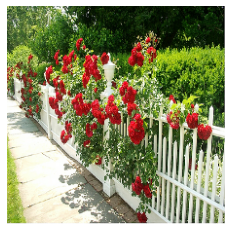

In [22]:
# Take a sample image from the validation dataset and show it.
single_image = next(iter(val_dataset.unbatch().take(1)))[0]
single_image_viz = (single_image.numpy().transpose(1, 2, 0) * std + mean).numpy()
single_image_viz = (single_image_viz - single_image_viz.min()) / (
    single_image_viz.max() - single_image_viz.min()
)

plt.imshow(single_image_viz)
plt.axis("off")
plt.show()

In [25]:
predictions = model.predict(single_image[None, ...])
label = classes[predictions.logits.argmax()]

print(f"Predicted label is: {label}")

Predicted label is: tulips


## Push to model hub

You can now upload trained model to the Hub. Just execute this instruction below:

In [ ]:
from huggingface_hub import push_to_hub_keras, from_pretrained_keras

# Push to HuggingFace Hub
push_to_hub_keras(model, "sayakpaul/vit-finetuned-flowers-tf")

# Reload from HuggingFace Hub
reloaded = from_pretrained_keras("sayakpaul/vit-finetuned-flowers-tf")

You can now share this model with all your friends, family, favorite pets: they can all load it with the identifier `"your-username/the-name-you-picked"` so for instance:

```py
from transformers import TFAutoModelForImageClassification

model = TFAutoModelForImageClassification.from_pretrained("sayakpaul/my-awesome-model")

```